# Face Generation

In this project, I am using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train a DCGAN. Human faces contain veery complex features that are hard for even modern neural networks to extract. I have a feeling that this challenge will be quite fun for me but not the gpu that it is training on. 

<img src='assets/processed_face_data.png' width=60% />

In [1]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize Data

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """Batch the neural network data using DataLoader"""
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor()])
    
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    return data_loader

## Create a DataLoader

In [5]:
# hyperparameters
batch_size = 128
img_size = 32

celeba_train_loader = get_dataloader(batch_size, img_size)

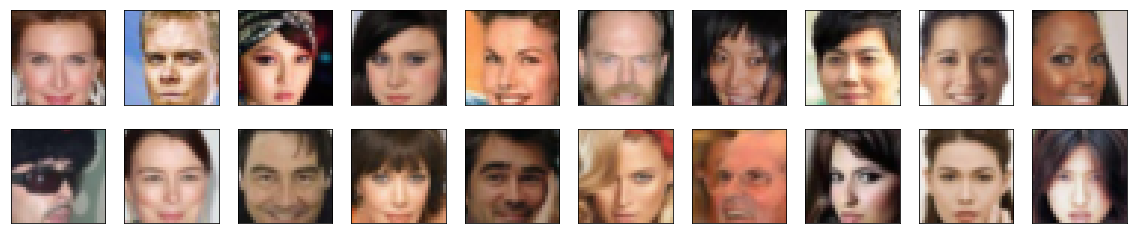

In [6]:
# helper display function to see images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(celeba_train_loader)
images, _ = dataiter.next()

fig = plt.figure(figsize=(20,4))
plot_size = 20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

## Pro-process: Scaling

In [7]:
def scale(x, feature_range=(-1, 1)):
    '''Scale takes in an image and scales it from -1 to 1'''

    min, max = feature_range
    x = x * (max - min) + min
    
    return x

# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    '''helper function for constructing 2d convolutional layers with batch normalization'''
    
    layers=[]
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    
    if (batch_norm):
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """Initialize the Discriminator Module"""
        
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        
        # 32*32 input first layer (no batch norm)
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        # 16*16
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8*8
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4*4
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        # 2*2
        
        # fully connected
        self.fc = nn.Linear(conv_dim*8*2*2, 1)

    def forward(self, x):
        """Forward propagation of the neural network"""
        
        # leaky relu with neg slope of 0.2, overwrite x since no ResNet
        # hidden layers
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        
        # flatten
        x = x.view(-1, self.conv_dim*8*2*2)
        
        # output (no binary classification yet)
        x = self.fc(x)
        
        return x

# check if discriminator makes sense
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

In [11]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    '''helper function for constructing 2d deconvolutional layers with batch normalization'''
    
    layers=[]
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(transpose_conv_layer)
    
    if (batch_norm):
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """Initialize the Generator Module"""
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        
        # first layer fully connected
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)
        
        # tranpose conv layers
        self.deconv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.deconv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv3 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv4 = deconv(conv_dim, 3, 4, batch_norm=False) # no normalization for final

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        # construct image shape
        x = x.view(-1, self.conv_dim*8, 2 ,2)
        
        # hidden deconv
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        
        # tanh activation
        x = torch.tanh(self.deconv4(x))
        
        return x

    
# check if generator makes sense
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of networks
Parameter values from [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf)

In [13]:
def weights_init_normal(m):
    """ The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02. """
    classname = m.__class__.__name__
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        m.weight.data.normal_(0.0, 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.zero_()
    

## Build complete network

In [14]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print("-----------------------------------")
    print(G)
    
    return D, G

In [15]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)
-----------------------------------
Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stri

### Training on GPU

In [16]:
import torch

# Check for GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


## Discriminator and Generator Losses

In [17]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real'''
    batch_size = D_out.size(0)
    # smoothen with 0.9 to go easier on the discriminator
    labels = torch.ones(batch_size)*0.9
    
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

In [18]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

## Training (literally move everything we could to GPU)

In [19]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, fake samples
    samples = []
    losses = []

    # Get some fixed data for sampling
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            if train_on_gpu:
                real_images = real_images.cuda()

            # ===============================================
            #               TRAIN THE NETWORKS
            # ===============================================
            
            # DISCRIMINATOR
            d_optimizer.zero_grad()
            
            # real image
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # fake image
            z = np.random.uniform(-1,1,size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # total and backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # GENERATOR
            g_optimizer.zero_grad()
            
            # fool discriminator
            z = np.random.uniform(-1,1,size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            
            # backprop
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                losses.append((d_loss.item(), g_loss.item()))
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        # generate and save samples
        G.eval()
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train()

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses

In [20]:
n_epochs = 30

# the game of patience
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   30] | d_loss: 1.3036 | g_loss: 1.3521
Epoch [    1/   30] | d_loss: 0.9633 | g_loss: 6.6072
Epoch [    1/   30] | d_loss: 0.5570 | g_loss: 3.5354
Epoch [    1/   30] | d_loss: 0.8070 | g_loss: 3.9397
Epoch [    1/   30] | d_loss: 0.7982 | g_loss: 2.4386
Epoch [    1/   30] | d_loss: 0.8233 | g_loss: 1.9912
Epoch [    1/   30] | d_loss: 0.7043 | g_loss: 2.2888
Epoch [    1/   30] | d_loss: 1.2507 | g_loss: 1.3769
Epoch [    1/   30] | d_loss: 0.8926 | g_loss: 2.2265
Epoch [    1/   30] | d_loss: 0.6581 | g_loss: 2.9949
Epoch [    1/   30] | d_loss: 0.8164 | g_loss: 2.6510
Epoch [    1/   30] | d_loss: 0.8555 | g_loss: 2.9629
Epoch [    1/   30] | d_loss: 1.0304 | g_loss: 1.2635
Epoch [    1/   30] | d_loss: 0.7898 | g_loss: 2.1042
Epoch [    1/   30] | d_loss: 0.9536 | g_loss: 3.1780
Epoch [    2/   30] | d_loss: 1.2510 | g_loss: 1.5576
Epoch [    2/   30] | d_loss: 0.8449 | g_loss: 2.1352
Epoch [    2/   30] | d_loss: 0.8949 | g_loss: 1.6370
Epoch [    2/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.8277 | g_loss: 1.3446
Epoch [   11/   30] | d_loss: 0.8786 | g_loss: 1.1586
Epoch [   11/   30] | d_loss: 1.1040 | g_loss: 2.6626
Epoch [   11/   30] | d_loss: 0.7822 | g_loss: 1.5946
Epoch [   11/   30] | d_loss: 1.1167 | g_loss: 1.1387
Epoch [   11/   30] | d_loss: 0.7738 | g_loss: 2.2726
Epoch [   11/   30] | d_loss: 0.8913 | g_loss: 1.9985
Epoch [   11/   30] | d_loss: 0.6204 | g_loss: 1.8780
Epoch [   11/   30] | d_loss: 0.8220 | g_loss: 1.9905
Epoch [   11/   30] | d_loss: 1.0624 | g_loss: 1.3111
Epoch [   11/   30] | d_loss: 0.6247 | g_loss: 2.0101
Epoch [   11/   30] | d_loss: 0.6323 | g_loss: 1.6692
Epoch [   11/   30] | d_loss: 1.0560 | g_loss: 2.0546
Epoch [   12/   30] | d_loss: 0.7332 | g_loss: 1.5872
Epoch [   12/   30] | d_loss: 0.7961 | g_loss: 1.7238
Epoch [   12/   30] | d_loss: 1.3837 | g_loss: 3.4799
Epoch [   12/   30] | d_loss: 0.7054 | g_loss: 2.0977
Epoch [   12/   30] | d_loss: 0.9591 | g_loss: 1.4045
Epoch [   12/   30] | d_loss

Epoch [   21/   30] | d_loss: 0.7070 | g_loss: 2.3001
Epoch [   21/   30] | d_loss: 0.8024 | g_loss: 1.0609
Epoch [   21/   30] | d_loss: 0.5378 | g_loss: 2.0396
Epoch [   21/   30] | d_loss: 0.6855 | g_loss: 2.2599
Epoch [   21/   30] | d_loss: 0.4735 | g_loss: 2.5094
Epoch [   21/   30] | d_loss: 0.5847 | g_loss: 2.3934
Epoch [   21/   30] | d_loss: 0.6477 | g_loss: 1.5231
Epoch [   21/   30] | d_loss: 0.5918 | g_loss: 2.3659
Epoch [   21/   30] | d_loss: 0.7348 | g_loss: 2.6687
Epoch [   21/   30] | d_loss: 2.1919 | g_loss: 0.6016
Epoch [   21/   30] | d_loss: 0.5739 | g_loss: 2.4941
Epoch [   22/   30] | d_loss: 0.7194 | g_loss: 2.5106
Epoch [   22/   30] | d_loss: 0.4553 | g_loss: 2.8673
Epoch [   22/   30] | d_loss: 0.4601 | g_loss: 3.0899
Epoch [   22/   30] | d_loss: 0.6993 | g_loss: 3.2128
Epoch [   22/   30] | d_loss: 0.5101 | g_loss: 4.1814
Epoch [   22/   30] | d_loss: 0.5910 | g_loss: 3.0668
Epoch [   22/   30] | d_loss: 0.6501 | g_loss: 1.8406
Epoch [   22/   30] | d_loss

## Training loss

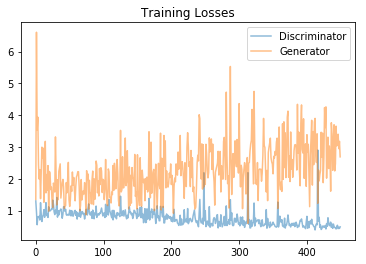

In [21]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

In [22]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [23]:
# load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

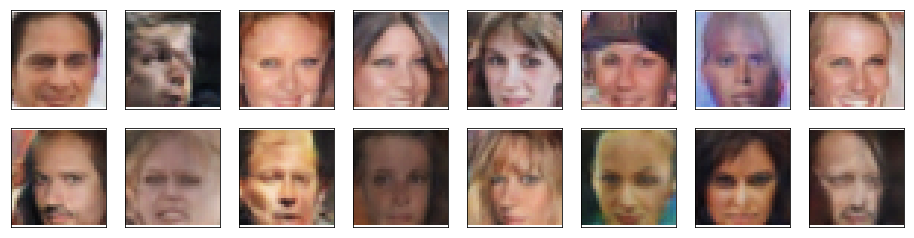

In [24]:
_ = view_samples(-1, samples)